My implementation of the Hilbert Huang transform ([PyHHT](https://github.com/jaidevd/pyhht)) is quite close to a beta release. After nearly three years of inactivity, I've found some time to develop the PyHHT library in the last few weeks. In all this time many people have written to me about a lot of things - from the inability to use the module because of the lack of documentation, to comparison between the results of HHT and conventional time series analysis techniques. And now the time has come when I can no longer avoid writing the documentation. But as I write the documentation, I've found that I need to re-learn the concepts which I learned back when I started writing this module. It is out of this learning cycle that came my last [blog post](http://jaidevd.github.io/blog/understanding-edge-effects-in-emd/).

This blog post is the second in a series of posts in which I will discuss HHT in detail. (After all I've always thought that blogging is a lot more fun than writing documentation. This really doesn't bode well for my software development habits, but here I am.)
<!-- TEASER_END -->

Prologue
---------

Methods based on the Fourier transform are almost synonymous with frequency domain
processing of signals (funnily, I once had a classmate who thought "Fourier"
was French for frequency). There is no doubt about how incredibly powerful Fourier
analysis can be. However, its popularity and effectiveness have a downside. It
has led to a very specific and limited view of frequency in the context of
signal processing. Simply put, frequencies, in the context of Fourier methods,
are just a collection of the individual frequencies of periodic signals that a
given signal is composed of. The purpose of these articles is to demonstrate
how restrictive this interpretation of frequency can be in some cases, and to lay the groundwork for
complementary methods, like the Hilbert spectral analysis.

This is not to say that Hilbert spectral analysis can in any way replace
Fourier, but that it provides an alternative interpretation of frequency, and
an alternative view of nonlinear and nonstationary phenomena.

The Problem
-------------

**Note**: To run the code snippets on this page, you will need the PyTFTB module, which can be found [here](http://github.com/scikit-signal/pytftb).

To begin with, let us construct a nonstationary signal, and try to glean its time and frequency characteristics. Consider the signal obtained as follows:

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tftb.generators import fmconst
%matplotlib inline

In [2]:
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10.0, 8.0)

(0, 256)

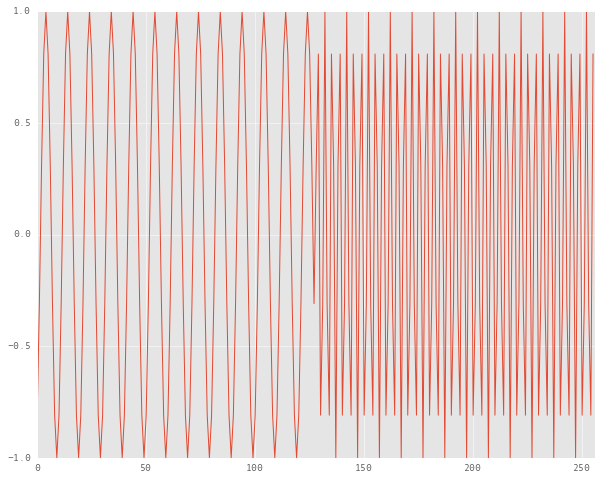

In [3]:
n_points = 128
mode1, iflaw1 = fmconst(n_points, fnorm=0.1)
mode2, iflaw2 = fmconst(n_points, fnorm=0.3)
signal = np.r_[mode1, mode2]
plt.plot(np.real(signal))
plt.xlim(0, 256)

This first half of the signal is a sinusoid with a normalized frequency of 0.1
and the other half has a normalized frequency of 0.3. If we look at the energy
spectrum of this signal, sure enough, there are two peaks at the respective
frequencies:

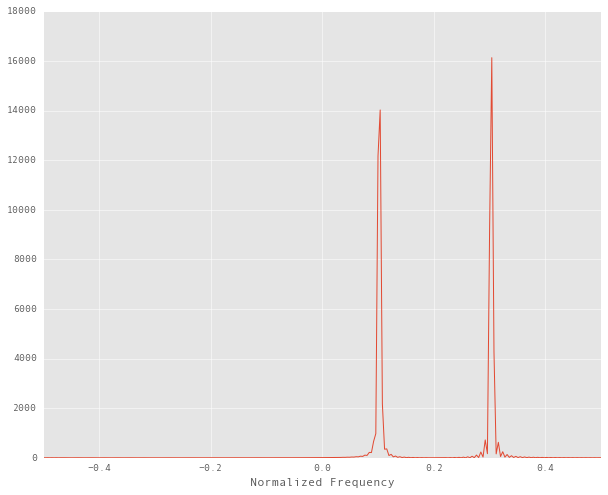

In [4]:
X = np.fft.fftshift(np.fft.fft(signal))
plt.plot(np.linspace(-0.5, 0.5, 256), np.abs(X) ** 2)
plt.xlim(-0.5, 0.5)
plt.xlabel("Normalized Frequency")

Note that the signal produced by the [`fmconst`](http://pytftb.readthedocs.org/en/latest/apiref/tftb.generators.html#tftb.generators.frequency_modulated.fmconst) function produces an [Analytic
Signal](https://en.wikipedia.org/wiki/Analytic_signal). Analytic signals are complex
valued, and by definition do not have negative frequency components.

A note on time-frequency analysis
--------------------------------------

The energy spectrum is perfectly valid, but the Fourier transform is
essentially an integral over time. Thus, we lose all information that varies
with time. All we can tell from the spectrum is that the signal has two
distinct frequency components. In other words, we can comment on *what*
happens a signal, not *when* it happens. Consider a song as the signal under
consideration. If you were not interested in time, the whole point of
processing that signal would be lost. Rhythm and timing are the very heart of
good music, after all. In this case, we want
to know when the drums kicked in, as well as what notes were being played on
the guitar. If we perform only frequency analysis, all time information would
be lost and the only information we would have would be about what frequencies
were played in the song, and what their respective amplitudes were, averaged
over the duration of the entire song. So even if the drums stop playing after
the second stanza, the frequency spectrum would show them playing throughout
the song. Conversely, if we were only interested in the time information, we
would be hardly better off than simply listening to the song.

The solution to this is [time-frequency
analysis](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis), which
is a field that deals with signal processing in both time and frequency domain.
It consists of a collection of methods that allow us to make tradeoffs between
time and frequency processing of a signal, depending on what makes more sense
for a particular application. HHT too is a tool for time-frequency analysis,
as we shall see.

Time-Frequency representations of the signal
---------------------------------------------------

A popular choice to represent both time and frequency characteristics is the
[short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), which, simply
put, transforms contiguous chunks of the input and aggregates the result in a 2
dimensional form, where one axis represents frequency and the other represents
time. PyTFTB has an [STFT implementation](http://pytftb.readthedocs.org/en/latest/apiref/tftb.processing.html#tftb.processing.linear.ShortTimeFourierTransform) which we can use as follows:


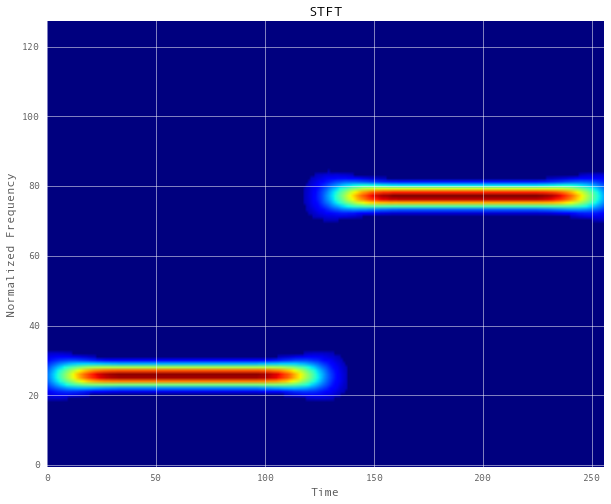

In [5]:
from tftb.processing import ShortTimeFourierTransform
stft = ShortTimeFourierTransform(signal)
stft.run()
stft.plot()

This representation is quite statisfactory. However, there are a number of
reasons why it might not always work.

First of all, the short time Fourier
transform is parameterized by two important things, other than the signal
itself - the number of bins into which the frequency range of the signal is
partitioned, and the window function used for smoothing the frequencies. Let's
see what happens when we vary the number of frequency bins and the length of
the window function.

![](http://pyhht.readthedocs.org/en/latest/_images/intro_tf_grid.png)

The number of frequency bins increases from top to bottom and the length of the
window function increases from left to right. Notice that the representation we
are looking for is at the bottom right corner, obtained with 256 frequency bins
and a (Hamming) window of length 65. Note that the PyTFTB implementation of the
STFT is naive - the default number of frequency bins it uses is equal to the
length of the input signal. We can, of course, specify a smaller number, but
anything less than 256 would lead to a less than ideal representation.
Moreover, these many bins sufficed in this particular case because the
frequencies in the input signal are relatively low, in that a sufficient number
of cycles can be accommodated within 256 samples. Also, the frequency
components are sufficiently separated for the window function to distinguish between them
properly. Thus, to find a suitable time-frequency for an arbitrary
nonstationary signal, it is likely that we might end up searching the grid
shown above, which is highly impractical.

A counterexample
-------------------

As an example of how this approach can go wrong, take a look at the following
signal:

(0, 256)

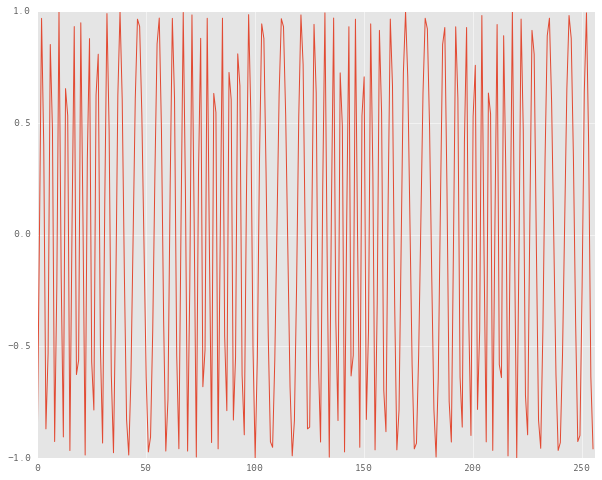

In [6]:
from tftb.generators import fmsin
sig, iflaw = fmsin(256, 0.1, 0.3, period=64)
plt.plot(np.real(sig))
plt.xlim(0, 256)

This signal contains frequencies which are modulated such that they vary
sinusoidally between 0.1 and 0.3. The time-frequency distribution of this
signal should look somewhat like a sine wave. Here's the spectrogram of the
STFT of this signal:

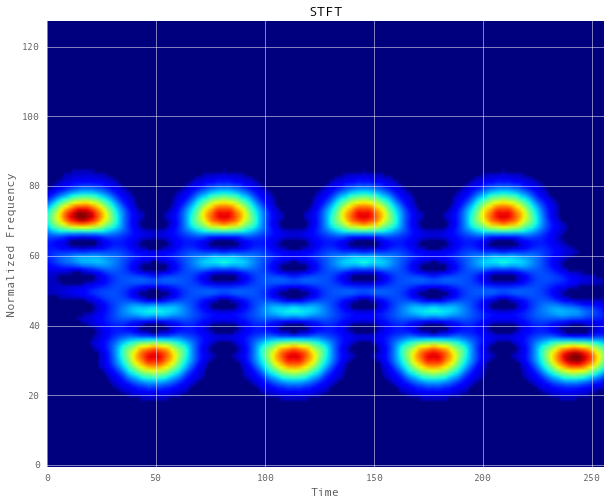

In [7]:
stft = ShortTimeFourierTransform(sig)
stft.run()
stft.plot()

From this representation, the sinusoidal nature of the frequencies can be made
out. And it also makes sense that the concentration of energy is the highest at the extrema of the sine wave. But the artifacts between the high energy areas are quite ambiguous, and
bear little resemblance to the signal's true characterisitcs.

Of course, there are a number of heuristics one can apply to make this
representation more reasonable - like tweaking the parameters of the STFT,
increasing the sampling frequency of the signal, or to use another
time-frequency representation altogether. Unfortunately none of these methods
are fully data driven, in that they rely very strongly on a parametric model of
the data, and the representation is only as good as the model. A major drawback
of time frequency distributions that depend on Fourier or wavelet models is
that they don't allow for an "unsupervised" or data driven approach to time
series analysis.

The Hilbert Huang transform fixes this to a great extent. The following
posts will deal with how Hilbert spectral analysis is better suited for
nonlinear and nonstationary time series data, and how the empirical mode
decomposition algorithm makes the results of the Hilbert spectral analysis more reasonable.